# 0. Введение

Цель практики - тренировка подбора гиперпараметров моделей МО:
* Обучить две модели: логистическую регрессию и случайный лес;  
* Выполнить подбор гиперпараметров с помощью базовых (`GridSeachCV, RandomizedSearchCV`) и продвинутых (`Hyperopt, Optuna`) методов оптимизации так, чтобы улучшать итоговую метрику;   
* Провести сравнение и понять преимущества и недостатки каждого из методов.

In [ ]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

In [ ]:
# подключаем google диск, где у нас хранятся данные
from google.colab import drive
drive.mount('/content/drive')
# берем необходимый нам файл с диска, указав путь
data = pd.read_csv('./_train_sem09 (1).csv')
data.head()

Mounted at /content/drive


,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


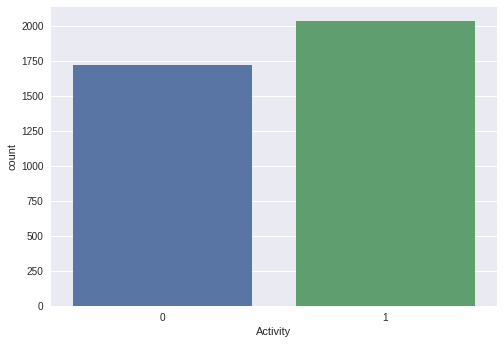

In [ ]:
# Посмотрим на сбалансированность классов:
sns.countplot(data=data, x='Activity');

Довольно сбалансированные классы

In [ ]:
# Создадим матрицу наблюдений X и столбец с ответами y
X = data.drop(['Activity'], axis=1)
y = data['Activity']

In [ ]:
# Разделим данные на обучающую и тестовую части
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

# 1. Обучаем две модели: логистическую регрессию и случайный лес

## 1.1. Создаем объект класса **логистическая регрессия** (**LR**)

In [ ]:
# Создаем объект класса логистическая регрессия
lr = linear_model.LogisticRegression(max_iter = 50)
# Обучаем модель
lr.fit(X_train, y_train)

# Выводим значения метрики:
#для тренировочных данных
y_train_pred_lr = lr.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_lr))) 
#для тестовых данных
y_test_pred_lr = lr.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_lr)))

f1_score на обучающем наборе: 0.87
f1_score на тестовом наборе: 0.79


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Без дополнительной настройки для **Логистической регрессии** получены значения метрики _F1-score_ на: обучающем наборе 0.87, тестовом наборе 0.79.

## 1.2. Создаем объект класса **случайный лес** (**RF**)

In [ ]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)
# Обучаем модель
rf.fit(X_train, y_train)

# Выводим значения метрики
#для тренировочных данных
y_train_pred_rf = rf.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_rf)))
#для тестовых данных
y_test_pred_rf = rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rf)))

f1_score на обучающем наборе: 1.00
f1_score на тестовом наборе: 0.81


Без дополнительной настройки для **Случайного леса** получены значения метрики _F1-score_ на: обучающем наборе 1.0, тестовом наборе 0.81. Методом случайного леса метрика _F1-score_ на тестовом наборе несколько лучше, чем методом логистической регрессии 0.81 против 0.79.

# 2. Подбор гиперпараметров с помощью базовых методов оптимизации

## 2.1. Подбор гиперпараметров для алгоритма **Логистической регрессии** методом **GridSearchCV (GSCV).**

In [1]:
from sklearn.model_selection import GridSearchCV # Импортируем библиотеку GridSearchCV

# Создадим словарь искомых гиперпараметров
param_grid_lr = [
              {'penalty': ['l2', None] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}
                ]
# Вызываем класс GridSearchCV и передаем модель LogisticRegression и прочие данные для расчетов,
grid_search_lr = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=50 #количество итераций на сходимость
    ), 
    param_grid=param_grid_lr, 
    cv=5, 
    n_jobs = -1
)  

%%time

grid_search_lr.fit(X_train, y_train) 
y_train_pred = grid_search_lr.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search_lr.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_lr.best_params_))

NameError: name 'np' is not defined

Для **Логистической регрессии** получены следующие значения _F1-score_ при подборе гиперпараметров методом GridSearchCV на: обучающем наборе - 0.86, тестовом наборе - 0.78. Улучшить метрику для логистической регрессии с помощью **GSCV** не удалось.

In [ ]:
# Взглянем на результаты кросс-валидации
result_cv = pd.DataFrame(grid_search_lr.cv_results_)
result_cv.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.774005,0.123558,0.030203,0.002719,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.736667,0.765000,0.780000,0.745,0.746667,0.754667,0.015684,21
1,5.297659,0.542160,0.041453,0.020640,0.01,l2,sag,"{'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}",0.738333,0.763333,0.781667,0.745,0.745000,0.754667,0.015861,21


In [ ]:
result_cv.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_penalty', 'param_solver', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

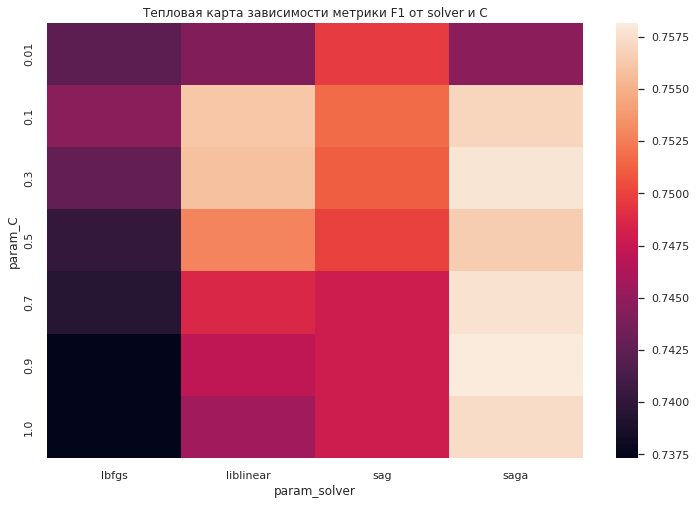

In [ ]:
# Отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_lr.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики F1 от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

Видим, что слабая регуляризация С = 0,01 отрицательно влияет на метрику, поэтому есть смысл брать значения больше 0,05 и  алгоритмы оптимизации: _liblinear_, _sag_ и _saga_ возможно отработают лучше. К сожалению, не отработал алгоритм _lbfgs_ из-за превышения количества итераций, возможно есть смысл заменить его на другой алгоритм, т.к. по условиям задания увеличивать количество итераций нельзя.

## 2.2. Подбор гиперпараметров для алгоритма **Случайный лес** методом **GridSearchCV** (**GSCV**)

In [ ]:
# Создадим словарь искомых гиперпараметров
param_grid_rf = {'n_estimators': list(range(80, 200, 10)),
              'min_samples_leaf': list(range(2, 10, 1)),
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
# Вызываем класс GridSearchCV и передаем модель RandomForestClassifier и прочие данные для расчетов,
grid_search_rf = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid_rf, 
    cv=5, 
    n_jobs = -1
)  

%%time

grid_search_rf.fit(X_train, y_train) 
y_train_pred = grid_search_rf.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search_rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_rf.best_params_))

CPU times: user 30.3 s, sys: 2.87 s, total: 33.2 s
Wall time: 1h 39s
f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.83
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 140}


Для **Случайного леса** получены следующие значения _F1-score_ при подборе гиперпараметров методом GridSearchCV на: обучающем наборе - 0.99, на тестовом наборе - 0.83. Удалось улучшить метрику случайный лес с помощью **GSCV** со 0.81 до 0.83.

## 2.3. Подбор гиперпараметров для алгоритма **Логистической регрессии** методом **RandomizedSearchCV** (**RSCV**)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV # импортируем RandomizedSearchCV

# Создадим словарь искомых гиперпараметров
param_distributions_lr = [
              {'penalty': ['l2', None] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))}
                ]

# Вызываем класс RandomizedSearchCV и передаем модель LogisticRegression и прочие данные для расчетов            
random_search_lr = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_distributions=param_distributions_lr, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
    )  

%%time

random_search_lr.fit(X_train, y_train) 
y_train_pred = random_search_lr.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_lr.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_lr.best_params_))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 11.4 µs
f1_score на обучающем наборе: 0.87
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.23}


Для **Логистической регрессии** получены следующие значения _F1-score_ при подборе гиперпараметров методом RandomizedSearchCV на: обучающем наборе - 0.87, тестовом наборе - 0.79. Улучшить метрику логистической регрессии с помощью **RSCV** не удалось.

## 2.4. Подбор гиперпараметров для алгоритма **Случайный лес** методом **RandomizedSearchCV** (**RSCV**)

In [ ]:
# Создадим словарь искомых гиперпараметров
param_distributions_rf = {'n_estimators': list(range(80, 200, 10)),
              'min_samples_leaf': list(range(2, 10, 1)),
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }

# Вызываем класс GridSearchCV и передаем модель RandomForestClassifier и прочие данные для расчетов,            
random_search_rf = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions_rf, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1
)  

%%time

random_search_rf.fit(X_train, y_train) 
y_train_pred = random_search_rf.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_rf.best_params_))

CPU times: user 6.78 s, sys: 401 ms, total: 7.18 s
Wall time: 6min 32s
f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.83
Наилучшие значения гиперпараметров: {'n_estimators': 160, 'min_samples_leaf': 2, 'max_depth': 20}


Для **Случайного леса** получены следующие значения _F1-score_ при подборе гиперпараметров методом RandomizedSearchCV на: обучающем наборе - 0.99, тестовом наборе: 0.83. Улучшить метрику случайного леса с помощью **RSCV** не удалось.

# 3. Подбор гиперпараметров с помощью продвинутых методов оптимизации

## 3.1. Подбор гиперпараметров для алгоритма **Логистическая регрессия** методом **Hyperopt**

In [ ]:
# Устанавливаем библиотеку
%pip install hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#делаем импорт и выведем версию библиотеки
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

print("Версия Hyperopt : {}".format(hyperopt.__version__))

Версия Hyperopt : 0.2


In [ ]:
# зададим пространство поиска гиперпараметров
space_lr= {
          'penalty': hp.choice('penalty', ['l1', 'l2']),
          'solver': hp.choice('solver', ['liblinear', 'saga']),
          'C': hp.quniform('C', 0.1, 1, 0.1)
          }

In [ ]:
# зафиксируем random_state
random_state = 42
def hyperopt_lr(params_lr, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params_lr = {'penalty': (params_lr['penalty']), 
              'solver': (params_lr['solver']), 
              'C': float(params_lr['C'])
              }
  
    # используем эту комбинацию для построения модели
    model_lr_ho = linear_model.LogisticRegression(**params_lr, random_state=random_state, max_iter=50)

    # обучаем модель
    model_lr_ho.fit(X, y)
    score = metrics.f1_score(y, model_lr_ho.predict(X))
    
    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [ ]:
# начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов

%%time

best = fmin(
          hyperopt_lr, # наша функция 
          space=space_lr, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state) # фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs
  2%|▏         | 1/50 [00:03<03:00,  3.68s/it, best loss: -0.8634978671541743]

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 10%|█         | 5/50 [00:11<01:59,  2.65s/it, best loss: -0.8823709135349832]

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 12%|█▏        | 6/50 [00:17<02:44,  3.74s/it, best loss: -0.8823709135349832]

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 22%|██▏       | 11/50 [00:26<01:51,  2.87s/it, best loss: -0.8823709135349832]

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 26%|██▌       | 13/50 [00:31<01:49,  2.96s/it, best loss: -0.8823709135349832]

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 34%|███▍      | 17/50 [00:38<01:20,  2.44s/it, best loss: -0.8823709135349832]

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 38%|███▊      | 19/50 [00:48<02:09,  4.18s/it, best loss: -0.8823709135349832]

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 62%|██████▏   | 31/50 [01:00<00:38,  2.02s/it, best loss: -0.8856968215158926]

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 70%|███████   | 35/50 [01:06<00:27,  1.83s/it, best loss: -0.8856968215158926]

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 78%|███████▊  | 39/50 [01:13<00:26,  2.45s/it, best loss: -0.8856968215158926]

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 84%|████████▍ | 42/50 [01:20<00:21,  2.73s/it, best loss: -0.8856968215158926]

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 92%|█████████▏| 46/50 [01:29<00:12,  3.06s/it, best loss: -0.8856968215158926]

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



 98%|█████████▊| 49/50 [01:35<00:02,  2.77s/it, best loss: -0.8856968215158926]

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



100%|██████████| 50/50 [01:36<00:00,  1.93s/it, best loss: -0.8856968215158926]
Наилучшие значения гиперпараметров {'C': 1.0, 'penalty': 1, 'solver': 0}


In [ ]:
# Рассчитаем точность для тестовой выборки
model_lr_ho = linear_model.LogisticRegression(
    random_state=random_state, 
    C= best['C'], 
    penalty = 'l2', 
    solver = 'liblinear'
)

model_lr_ho.fit(X_train, y_train)
y_train_pred = model_lr_ho.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model_lr_ho.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.89
f1_score на тестовом наборе: 0.78


Для **Логистической регрессии** получены следующие значения _F1-score_ при подборе гиперпараметров методом **Hyperopt** на: обучающем наборе - 0.89, тестовом наборе - 0.78. Улучшить метрику логистической регрессии с помощью **Hyperopt** не удалось.

## 3.2. Подбор гиперпараметров для алгоритма **Случайный лес** методом **Hyperopt**

In [ ]:
# Зададим пространство поиска гиперпараметров
space_rf={'n_estimators': hp.quniform('n_estimators', 80, 200, 10),
       'max_depth' : hp.quniform('max_depth', 20, 40, 5),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [ ]:
# Зафиксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # Функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # Используем эту комбинацию для построения модели
    model_rf = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # Обучаем модель
    model_rf.fit(X, y)
    score = metrics.f1_score(y, model_rf.predict(X))

    # Метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [ ]:
# Начинаем подбор гиперпараметров
trials = Trials() # используется для логирования результатов

%%time

best=fmin(hyperopt_rf, # наша функция 
          space=space_rf, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state) # фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 50/50 [02:12<00:00,  2.64s/it, best loss: -0.9920294297976702]
Наилучшие значения гиперпараметров {'max_depth': 25.0, 'min_samples_leaf': 2.0, 'n_estimators': 140.0}


In [ ]:
# Рассчитаем точность для тестовой выборки
model_rf = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)

model_rf.fit(X_train, y_train)
y_train_pred = model_rf.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model_rf.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.82


Для **Случайного леса** получены следующие значения _F1-score_ при подборе гиперпараметров методом **Hyperopt** на: обучающем наборе - 0.99, тестовом наборе: 0.82. Улучшить метрику с помощью **Hyperopt** случайного леса не удалось.

## 3.3. Подбор гиперпараметров для алгоритма **Логистическая регрессия** методом **Optuna**

In [ ]:
# Устанавливаем библиотеку
%pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.3 MB/s eta 0:00:00


In [ ]:
# Импортируем  библиотеку
import optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.1.0


In [ ]:
# Настроим оптимизацию гиперпараметров для алгоритма логистической регрессии.
def optuna_lr(trial):
  # Задаем пространства поиска гиперпараметров
  param_lr_opt={'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']), 
                'solver' : trial.suggest_categorical('solver', ['liblinear', 'saga']), 
                'C': trial.suggest_float('C', 0.1, 1, step = 0.1)
              }
  # Создаем модель
  model_lr_opt = linear_model.LogisticRegression(**param_lr_opt, random_state=random_state, max_iter=50)
  
  # Обучаем модель
  model_lr_opt.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model_lr_opt.predict(X_train))

  return score

In [ ]:
%%time

# Создаем объект исследования
study_lr = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_lr.optimize(optuna_lr, n_trials=50)

[I 2023-03-11 10:06:45,145] A new study created in memory with name: LogisticRegression
[I 2023-03-11 10:06:47,673] Trial 0 finished with value: 0.8681553992046498 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 1.0}. Best is trial 0 with value: 0.8681553992046498.
[I 2023-03-11 10:06:48,362] Trial 1 finished with value: 0.8023880597014925 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.1}. Best is trial 0 with value: 0.8681553992046498.
[I 2023-03-11 10:06:50,201] Trial 2 finished with value: 0.8604580152671755 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.8}. Best is trial 0 with value: 0.8681553992046498.
[I 2023-03-11 10:06:51,339] Trial 3 finished with value: 0.864567410577805 and parameters: {'penalty': 'l1', 'solver': 'liblinear', 'C': 0.9}. Best is trial 0 with value: 0.8681553992046498.
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did n

In [ ]:
# Выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_lr.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_lr.best_value))

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'liblinear', 'C': 1.0}
f1_score на обучающем наборе: 0.89


In [ ]:
# Рассчитаем точность для тестовой выборки
model_lr_opt = linear_model.LogisticRegression(**study_lr.best_params,random_state=random_state, )
model_lr_opt.fit(X_train, y_train)
y_train_pred = model_lr_opt.predict(X_train)
y_test_pred = model_lr_opt.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.78


Для **Логистической регрессии** получены следующие значения _F1-score_ при подборе гиперпараметров методом **Optuna** на: обучающем наборе - 0.89, тестовом наборе - 0.78. Улучшить метрику логистической регрессии с помощью **Optuna** не удалось.

## 3.4. Подбор гиперпараметров для алгоритма **Случайный лес** методом **Optuna**

In [ ]:
# Настроим оптимизацию гиперпараметров для алгоритма случайного леса.
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 80, 200, 10)
  max_depth = trial.suggest_int('max_depth', 20, 40, 5)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model_rf_opt = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model_rf_opt.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model_rf_opt.predict(X_train))

  return score

In [ ]:
%%time

# Cоздаем объект исследования
study_rf = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# Ищем лучшую комбинацию гиперпараметров n_trials раз
study_rf.optimize(optuna_rf, n_trials=50)

[I 2023-03-11 08:12:54,544] A new study created in memory with name: RandomForestClassifier
[I 2023-03-11 08:12:57,877] Trial 0 finished with value: 0.9779546846295162 and parameters: {'n_estimators': 110, 'max_depth': 35, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9779546846295162.
[I 2023-03-11 08:13:00,425] Trial 1 finished with value: 0.9593644974029942 and parameters: {'n_estimators': 130, 'max_depth': 40, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9779546846295162.
[I 2023-03-11 08:13:03,321] Trial 2 finished with value: 0.9089798411728772 and parameters: {'n_estimators': 170, 'max_depth': 30, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.9779546846295162.
[I 2023-03-11 08:13:07,944] Trial 3 finished with value: 0.928288068355203 and parameters: {'n_estimators': 190, 'max_depth': 20, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9779546846295162.
[I 2023-03-11 08:13:10,722] Trial 4 finished with value: 0.9456654456654457 and parameters: {'n_e

CPU times: user 3min 7s, sys: 1.67 s, total: 3min 8s
Wall time: 3min 16s


In [ ]:
# Выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_rf.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_rf.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 170, 'max_depth': 35, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.99


In [ ]:
# Рассчитаем точность для тестовой выборки
model_rf_opt = ensemble.RandomForestClassifier(**study_rf.best_params,random_state=random_state, )
model_rf_opt.fit(X_train, y_train)
y_train_pred = model_rf_opt.predict(X_train)
y_test_pred = model_rf_opt.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.82


Для **Случайного леса** получены следующие значения _F1-score_ при подборе гиперпараметров методом **Optuna** на: обучающем наборе - 0.99, тестовом наборе: 0.82. Улучшить метрику случайного леса с помощью **Optuna** не удалось.

# 4. Выводы

Значения метрик практически не изменились, это значит, что мы не нашли комбинацию внешних параметров лучше, чем были найдены без подбора гиперпараметров. Исключение составляет метод случайного леса, где метрика улучшилась с 0.81 до 0.83.